# Normalizing Depth to Euphotic Zone

Josie Donnelly

*Last updated 11.10.22*

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from statistics import mode
from datetime import datetime
from time import time
import random

import matplotlib.pyplot as plt
%matplotlib inline


## Preprocessing

In [2]:
# load merged dataset
path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
file = 'float_loc_data_new_vars2.csv'

date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df_orig = pd.read_csv(path + file, parse_dates=['date'], date_parser=date_parser)
df_orig


,float,latitude,longitude,cycleNumber,date,PRES,PSAL,TEMP,BBP700,CHLA,...,sat_pic,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,sat_adg_s,sat_bbp_s
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,3,35.539001,12.378333,0.001788,6.958747e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,4,35.539001,12.378333,0.001788,6.958747e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,6,35.539001,12.378667,0.001788,6.964993e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,8,35.539001,12.379000,0.001789,7.164887e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,10,35.539001,12.379000,0.001790,7.155517e-01,...,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33210612,7901001,17.330,-23.271,28,2022-05-23 11:34:00,968,34.916109,6.358057,0.000216,-3.686869e-05,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093
33210613,7901001,17.330,-23.271,28,2022-05-23 11:34:00,975,34.916280,6.346782,0.000216,-1.843434e-05,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093
33210614,7901001,17.330,-23.271,28,2022-05-23 11:34:00,977,34.916280,6.346782,0.000216,2.543358e-18,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093
33210615,7901001,17.330,-23.271,28,2022-05-23 11:34:00,982,34.916280,6.346782,0.000216,2.543358e-18,...,0.000142,0.000266,0.0122,59.995998,0.5624,0.001425,0.0086,0.1181,0.018,1.906093


In [3]:
df_orig.columns


Index(['float', 'latitude', 'longitude', 'cycleNumber', 'date', 'PRES', 'PSAL',
       'TEMP', 'BBP700', 'CHLA', 'short_date', 'sat_chl', 'sat_ipar',
       'sat_sst', 'sat_poc', 'sat_bbp_443', 'sat_a_678', 'sat_kd_490',
       'sat_nflh', 'sat_pic', 'sat_Rrs_678', 'sat_aph_443', 'sat_par',
       'sat_angstrom', 'sat_bb_678', 'sat_adg_443', 'sat_aot_869', 'sat_adg_s',
       'sat_bbp_s'],
      dtype='object')

In [4]:
df = df_orig[['float', 'cycleNumber', 'latitude', 'longitude', 'date', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443', 'PRES', 'TEMP', 'CHLA']]
# sat_chl: chlorophyll-a concentration
# sat_sst: sea surface temperature
# sat_pic: calcite concentration
# sat_par: photosynthetically available radiation
# sat_aph_443: absorption due to phytoplankton (443 nm)

# consider only the observations for which the target CHLA is available
df = df[~df['CHLA'].isna()].reset_index(drop=True)
df


,float,cycleNumber,latitude,longitude,date,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,TEMP,CHLA
0,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,3,12.378333,6.958747e-01
1,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,4,12.378333,6.958747e-01
2,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,6,12.378667,6.964993e-01
3,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,8,12.379000,7.164887e-01
4,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,10,12.379000,7.155517e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33076991,7901001,28,17.330,-23.271,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,968,6.358057,-3.686869e-05
33076992,7901001,28,17.330,-23.271,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,975,6.346782,-1.843434e-05
33076993,7901001,28,17.330,-23.271,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,977,6.346782,2.543358e-18
33076994,7901001,28,17.330,-23.271,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,982,6.346782,2.543358e-18


In [5]:
floats = np.unique(df['float'])
print(f'Number of unique floats: {len(floats)}')


Number of unique floats: 565


## Discribe estimation process and visualize CHLA dropoff for a few examples


Here is the procedure for estimating the bottom of the euphotic zone (refered to as the "euphotic floor"):

* Consider all CHLA values for each cycle of each float, ordered by raw depth (ascending)

* Starting at the depth at which the peak CHLA value occurs for that cycle, step through the CHLA values as depth decreases, considering one value at a time

* If the CHLA value at the depth considered is "close enough" to some near-zero error (chosen to be the maximum of these two values: the minimum CHLA value for the cycle, or 1% of the peak CHLA value for the cycle), consider this value to be smallest tolerable CHLA value; therefore the depth is consideration is taken as the euphotic floor.

* Disregard all depths below the determined euphotic floor.

* Divide all depths in the cycle by the euphotic floor estimate to obtain the normalized depth.

Note that there are a small handful of cycles that do not yield an estimate for the euphotic floor due to peaks at unreasonable depths, CHLA values never dropping near enough to zero, etc. These examples will have to be handled separately.

In [6]:
# function to plot a path of a float cycle on a map, colored by raw depth (PRES) by default
def plot_on_map(tmp_df, color_by='PRES', cmap='plasma_r', figsize=(10,4), title=None):
    land = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    land.plot(color='lightgray', figsize=figsize)
    plt.scatter(tmp_df['longitude'], tmp_df['latitude'], c=tmp_df[color_by], cmap=cmap, s=1, alpha=0.7)
    cbar = plt.colorbar(label=color_by)
    cbar.ax.invert_yaxis()
    if title is None:
        plt.title(f'Cycle {tmp_df.loc[0,"cycleNumber"]} of Float {tmp_df.loc[0,"float"]}')
    else:
        plt.title(title)
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    
    plt.show()
    

In [7]:
def plot_chla_dropoff(cycle_df, euphotic_floor_guess, figsize=(16,6)):
    plt.plot(cycle_df['PRES'], cycle_df['CHLA'])
    if euphotic_floor_guess is not None:
        plt.axvline(x=euphotic_floor_guess, color='r')
    plt.title(f'CHLA Dropoff for Cycle {cycle_df.loc[0,"cycleNumber"]} of Float {cycle_df.loc[0,"float"]}')
    plt.xlabel('raw depth')
    plt.ylabel('CHLA')
    
    plt.show()
    

Float 6903805, cycle 22
Number of observations in cycle: 451
Peak: 0.1787
Min after peak: 0.0000
Euphotic floor estimate: 173m


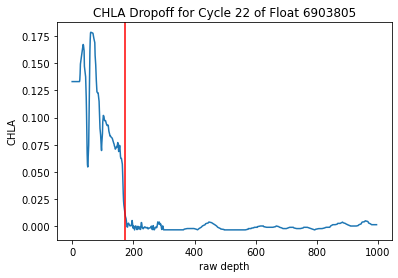

In [11]:
# plot path on map and CHLA dropoff for a random float-cycle
err = 0.01
euphotic_floor_guess = None
f = random.choice(floats)
# intetesting choices for float-cycle psirs: float 6902735, cycle 352; float 6901180, cycle 238
float_df = df[df['float'] == f]
cycles = np.unique(float_df['cycleNumber'])
c = random.choice(cycles)
cycle_df = float_df[float_df['cycleNumber'] == c].sort_values(by='PRES', ascending=True).reset_index(drop=True)
max_chla = max(cycle_df['CHLA'])
max_chla_idx = list(cycle_df['CHLA']).index(max_chla)
min_chla_after_peak = max(0, min(list(cycle_df['CHLA'])[max_chla_idx:]))
print(f'Float {f}, cycle {c}')
print(f'Number of observations in cycle: {cycle_df.shape[0]}')
print(f'Peak: {max_chla:.4f}')
print(f'Min after peak: {min_chla_after_peak:.4f}')

# obtain estimate for bottom of euphotic zone depth
chla_thresh = max(min_chla_after_peak, 0.01*max_chla)

# consider only values after the peak
for i in range(max_chla_idx, cycle_df.shape[0]):
    if cycle_df.loc[i,'CHLA'] - chla_thresh < err:
        euphotic_floor_guess = cycle_df.loc[i,'PRES']
        break

if euphotic_floor_guess is None:
    unit = ''
else:
    unit='m'
print(f'Euphotic floor estimate: {euphotic_floor_guess}{unit}')

# visualize the guess
plot_chla_dropoff(cycle_df, euphotic_floor_guess=euphotic_floor_guess)
# plot_on_map(cycle_df)


## Obtain euphotic floor estimates

In [14]:
# obtain bottom of euphotic zone estimates for all cycles
estimate_not_found = []
err = 0.01

# intialize dataframe to keep results
normalized_df = pd.DataFrame(columns=list(df.columns[:-2]) + ['normalized_depth'] + list(df.columns[-2:]))
normalized_df


,float,cycleNumber,latitude,longitude,date,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,normalized_depth,TEMP,CHLA


In [15]:
for num, f in enumerate(floats):
    float_df = df[df['float'] == f]
    cycles = np.unique(float_df['cycleNumber'])
    print(f'{num:<3} float {f:<9} ({len(cycles)} cycles)')
    
    float_results_df = pd.DataFrame(columns=list(df.columns[:-2]) + ['normalized_depth'] + list(df.columns[-2:]))
    
    for c in cycles:
        euphotic_floor_guess = None
    
        cycle_df = float_df[float_df['cycleNumber'] == c].sort_values(by='PRES', ascending=True).reset_index(drop=True)
        max_chla = max(cycle_df['CHLA'])
        max_chla_idx = list(cycle_df['CHLA']).index(max_chla)
        min_chla_after_peak = max(0, min(list(cycle_df['CHLA'])[max_chla_idx:]))

        # obtain estimate for bottom of euphotic zone depth
        chla_thresh = max(min_chla_after_peak, 0.01*max_chla)

        # consider only values after the peak
        for i in range(max_chla_idx, cycle_df.shape[0]):
            if cycle_df.loc[i,'CHLA'] - chla_thresh < err:
                euphotic_floor_guess = cycle_df.loc[i,'PRES']
                break

        if euphotic_floor_guess is None or euphotic_floor_guess < 75 or euphotic_floor_guess > 250:
            # guess is invalid
            estimate_not_found.append({'float': f, 'cycle': c, 'guess': euphotic_floor_guess})
            if euphotic_floor_guess is None:
                print(f'\tRetry: float {f}, cycle {c} -- guess: None')
            else:
                print(f'\tRetry: float {f}, cycle {c} -- guess: {euphotic_floor_guess}')
            # plot_chla_dropoff(cycle_df, euphotic_floor_guess=euphotic_floor_guess)
            continue

        # else, guess is valid; normalize and add results to dataframe
        cycle_df = cycle_df[cycle_df['PRES'] <= euphotic_floor_guess]
        if euphotic_floor_guess == 0:
            cycle_df.insert(loc=list(cycle_df.columns).index('PRES')+1, column='normalized_depth', value=list(cycle_df['PRES']))
        else:
            cycle_df.insert(loc=list(cycle_df.columns).index('PRES')+1, column='normalized_depth', value=[d/euphotic_floor_guess for d in cycle_df['PRES']])
        float_results_df = pd.concat([float_results_df, cycle_df])
        
    if float_results_df.shape[0] > 0:
        # if this float yielded results, add to final dataframe
        normalized_df = pd.concat([normalized_df, float_results_df])
        

0   float 1902303   (72 cycles)
	Retry: float 1902303, cycle 19 -- guess: 252
1   float 1902304   (91 cycles)
	Retry: float 1902304, cycle 6 -- guess: 62
	Retry: float 1902304, cycle 10 -- guess: 62
	Retry: float 1902304, cycle 59 -- guess: 61
	Retry: float 1902304, cycle 60 -- guess: 70
	Retry: float 1902304, cycle 62 -- guess: 62
	Retry: float 1902304, cycle 85 -- guess: 344
	Retry: float 1902304, cycle 87 -- guess: 308
2   float 1902380   (12 cycles)
3   float 1902381   (13 cycles)
4   float 1902382   (13 cycles)
5   float 1902383   (12 cycles)
	Retry: float 1902383, cycle 9 -- guess: 252
6   float 1902384   (12 cycles)
7   float 1902385   (12 cycles)
8   float 2902086   (213 cycles)
9   float 2902088   (201 cycles)
10  float 2902090   (6 cycles)
11  float 2902091   (12 cycles)
12  float 2902092   (58 cycles)
	Retry: float 2902092, cycle 68 -- guess: 68
	Retry: float 2902092, cycle 117 -- guess: 73
13  float 2902093   (188 cycles)
	Retry: float 2902093, cycle 44 -- guess: 58
	Retry:

23  float 2902131   (87 cycles)
	Retry: float 2902131, cycle 27 -- guess: 275
	Retry: float 2902131, cycle 29 -- guess: 305
	Retry: float 2902131, cycle 30 -- guess: 276
	Retry: float 2902131, cycle 62 -- guess: 276
	Retry: float 2902131, cycle 64 -- guess: 275
24  float 2902156   (106 cycles)
25  float 2902158   (96 cycles)
26  float 2902161   (1 cycles)
27  float 2902209   (18 cycles)
28  float 2902210   (13 cycles)
29  float 2902211   (18 cycles)
30  float 2902215   (12 cycles)
	Retry: float 2902215, cycle 188 -- guess: 452
	Retry: float 2902215, cycle 189 -- guess: 560
	Retry: float 2902215, cycle 195 -- guess: 416
31  float 2902216   (9 cycles)
32  float 2902238   (264 cycles)
33  float 2902240   (263 cycles)
34  float 2902241   (255 cycles)
35  float 2902242   (252 cycles)
36  float 2902243   (263 cycles)
37  float 2902244   (261 cycles)
38  float 2902245   (258 cycles)
39  float 2902263   (248 cycles)
	Retry: float 2902263, cycle 149 -- guess: 67
	Retry: float 2902263, cycle 151

	Retry: float 3901498, cycle 156 -- guess: 260
	Retry: float 3901498, cycle 231 -- guess: 272
	Retry: float 3901498, cycle 233 -- guess: 269
	Retry: float 3901498, cycle 234 -- guess: 253
	Retry: float 3901498, cycle 235 -- guess: 282
	Retry: float 3901498, cycle 242 -- guess: 260
	Retry: float 3901498, cycle 251 -- guess: 314
	Retry: float 3901498, cycle 252 -- guess: 270
	Retry: float 3901498, cycle 253 -- guess: 310
	Retry: float 3901498, cycle 267 -- guess: 263
	Retry: float 3901498, cycle 269 -- guess: 267
	Retry: float 3901498, cycle 285 -- guess: 290
	Retry: float 3901498, cycle 291 -- guess: 924
	Retry: float 3901498, cycle 324 -- guess: 286
	Retry: float 3901498, cycle 328 -- guess: 302
	Retry: float 3901498, cycle 329 -- guess: 290
	Retry: float 3901498, cycle 330 -- guess: 260
	Retry: float 3901498, cycle 331 -- guess: 262
	Retry: float 3901498, cycle 332 -- guess: 352
	Retry: float 3901498, cycle 333 -- guess: 370
	Retry: float 3901498, cycle 334 -- guess: 322
	Retry: float

85  float 5903612   (25 cycles)
86  float 5903711   (3 cycles)
87  float 5903714   (174 cycles)
88  float 5903717   (80 cycles)
	Retry: float 5903717, cycle 264 -- guess: 74
89  float 5903718   (152 cycles)
	Retry: float 5903718, cycle 34 -- guess: 251
	Retry: float 5903718, cycle 98 -- guess: 270
	Retry: float 5903718, cycle 100 -- guess: 290
	Retry: float 5903718, cycle 103 -- guess: 341
	Retry: float 5903718, cycle 105 -- guess: 390
	Retry: float 5903718, cycle 106 -- guess: 506
	Retry: float 5903718, cycle 107 -- guess: 386
	Retry: float 5903718, cycle 108 -- guess: 282
	Retry: float 5903718, cycle 109 -- guess: 322
	Retry: float 5903718, cycle 110 -- guess: 281
	Retry: float 5903718, cycle 113 -- guess: 482
	Retry: float 5903718, cycle 114 -- guess: 304
	Retry: float 5903718, cycle 116 -- guess: 438
	Retry: float 5903718, cycle 117 -- guess: 302
	Retry: float 5903718, cycle 120 -- guess: 264
	Retry: float 5903718, cycle 141 -- guess: 264
	Retry: float 5903718, cycle 167 -- guess: 

	Retry: float 5904185, cycle 120 -- guess: 270
	Retry: float 5904185, cycle 121 -- guess: 306
	Retry: float 5904185, cycle 122 -- guess: 298
	Retry: float 5904185, cycle 123 -- guess: 330
	Retry: float 5904185, cycle 124 -- guess: 279
	Retry: float 5904185, cycle 125 -- guess: 323
	Retry: float 5904185, cycle 126 -- guess: 340
	Retry: float 5904185, cycle 127 -- guess: 276
	Retry: float 5904185, cycle 128 -- guess: 262
	Retry: float 5904185, cycle 152 -- guess: 268
	Retry: float 5904185, cycle 154 -- guess: 294
	Retry: float 5904185, cycle 155 -- guess: 270
	Retry: float 5904185, cycle 161 -- guess: 378
	Retry: float 5904185, cycle 162 -- guess: 264
103 float 5904188   (154 cycles)
	Retry: float 5904188, cycle 17 -- guess: 252
	Retry: float 5904188, cycle 18 -- guess: 288
	Retry: float 5904188, cycle 20 -- guess: 272
	Retry: float 5904188, cycle 22 -- guess: 272
	Retry: float 5904188, cycle 23 -- guess: 290
	Retry: float 5904188, cycle 24 -- guess: 316
	Retry: float 5904188, cycle 25 -

	Retry: float 5904474, cycle 146 -- guess: 260
	Retry: float 5904474, cycle 147 -- guess: 356
	Retry: float 5904474, cycle 148 -- guess: 336
	Retry: float 5904474, cycle 149 -- guess: 256
115 float 5904475   (199 cycles)
	Retry: float 5904475, cycle 98 -- guess: 258
	Retry: float 5904475, cycle 140 -- guess: 254
	Retry: float 5904475, cycle 145 -- guess: 262
	Retry: float 5904475, cycle 147 -- guess: 264
	Retry: float 5904475, cycle 148 -- guess: 254
	Retry: float 5904475, cycle 149 -- guess: 258
	Retry: float 5904475, cycle 154 -- guess: 252
	Retry: float 5904475, cycle 173 -- guess: 270
116 float 5904476   (47 cycles)
117 float 5904477   (17 cycles)
	Retry: float 5904477, cycle 9 -- guess: 280
118 float 5904478   (4 cycles)
119 float 5904479   (108 cycles)
	Retry: float 5904479, cycle 4 -- guess: 296
	Retry: float 5904479, cycle 8 -- guess: 252
	Retry: float 5904479, cycle 9 -- guess: 272
	Retry: float 5904479, cycle 10 -- guess: 262
	Retry: float 5904479, cycle 11 -- guess: 258
	Ret

130 float 5904678   (165 cycles)
	Retry: float 5904678, cycle 18 -- guess: 326
	Retry: float 5904678, cycle 19 -- guess: 368
	Retry: float 5904678, cycle 20 -- guess: 348
	Retry: float 5904678, cycle 21 -- guess: 398
	Retry: float 5904678, cycle 22 -- guess: 476
	Retry: float 5904678, cycle 23 -- guess: 462
	Retry: float 5904678, cycle 24 -- guess: 634
	Retry: float 5904678, cycle 25 -- guess: 484
	Retry: float 5904678, cycle 54 -- guess: 252
	Retry: float 5904678, cycle 57 -- guess: 272
	Retry: float 5904678, cycle 58 -- guess: 266
	Retry: float 5904678, cycle 59 -- guess: 314
	Retry: float 5904678, cycle 60 -- guess: 300
	Retry: float 5904678, cycle 61 -- guess: 324
	Retry: float 5904678, cycle 62 -- guess: 304
	Retry: float 5904678, cycle 90 -- guess: 262
	Retry: float 5904678, cycle 91 -- guess: 283
	Retry: float 5904678, cycle 92 -- guess: 276
	Retry: float 5904678, cycle 93 -- guess: 338
	Retry: float 5904678, cycle 94 -- guess: 330
	Retry: float 5904678, cycle 95 -- guess: 294
	

138 float 5904687   (8 cycles)
139 float 5904688   (159 cycles)
	Retry: float 5904688, cycle 16 -- guess: 260
	Retry: float 5904688, cycle 17 -- guess: 480
	Retry: float 5904688, cycle 18 -- guess: 442
	Retry: float 5904688, cycle 19 -- guess: 313
	Retry: float 5904688, cycle 20 -- guess: 348
	Retry: float 5904688, cycle 21 -- guess: 453
	Retry: float 5904688, cycle 22 -- guess: 494
	Retry: float 5904688, cycle 23 -- guess: 500
	Retry: float 5904688, cycle 24 -- guess: 350
	Retry: float 5904688, cycle 25 -- guess: 480
	Retry: float 5904688, cycle 26 -- guess: 383
	Retry: float 5904688, cycle 30 -- guess: 283
	Retry: float 5904688, cycle 32 -- guess: 274
	Retry: float 5904688, cycle 41 -- guess: 306
	Retry: float 5904688, cycle 42 -- guess: 392
	Retry: float 5904688, cycle 43 -- guess: 268
	Retry: float 5904688, cycle 44 -- guess: 358
	Retry: float 5904688, cycle 45 -- guess: 268
	Retry: float 5904688, cycle 46 -- guess: 632
	Retry: float 5904688, cycle 47 -- guess: 534
	Retry: float 59

147 float 5904768   (30 cycles)
148 float 5904841   (160 cycles)
149 float 5904842   (155 cycles)
	Retry: float 5904842, cycle 23 -- guess: 280
	Retry: float 5904842, cycle 25 -- guess: 253
	Retry: float 5904842, cycle 26 -- guess: 292
	Retry: float 5904842, cycle 27 -- guess: 278
	Retry: float 5904842, cycle 28 -- guess: 298
	Retry: float 5904842, cycle 29 -- guess: 274
	Retry: float 5904842, cycle 30 -- guess: 258
	Retry: float 5904842, cycle 38 -- guess: 252
	Retry: float 5904842, cycle 56 -- guess: 260
	Retry: float 5904842, cycle 57 -- guess: 252
	Retry: float 5904842, cycle 59 -- guess: 260
	Retry: float 5904842, cycle 60 -- guess: 256
	Retry: float 5904842, cycle 65 -- guess: 272
	Retry: float 5904842, cycle 66 -- guess: 263
	Retry: float 5904842, cycle 70 -- guess: 294
	Retry: float 5904842, cycle 147 -- guess: 254
150 float 5904843   (177 cycles)
151 float 5904844   (196 cycles)
	Retry: float 5904844, cycle 1 -- guess: 280
	Retry: float 5904844, cycle 2 -- guess: 282
	Retry: f

152 float 5904845   (173 cycles)
	Retry: float 5904845, cycle 2 -- guess: 254
	Retry: float 5904845, cycle 20 -- guess: 268
	Retry: float 5904845, cycle 21 -- guess: 300
	Retry: float 5904845, cycle 22 -- guess: 292
	Retry: float 5904845, cycle 23 -- guess: 444
	Retry: float 5904845, cycle 24 -- guess: 494
	Retry: float 5904845, cycle 25 -- guess: 488
	Retry: float 5904845, cycle 26 -- guess: 598
	Retry: float 5904845, cycle 27 -- guess: 680
	Retry: float 5904845, cycle 28 -- guess: 712
	Retry: float 5904845, cycle 33 -- guess: 292
	Retry: float 5904845, cycle 35 -- guess: 388
	Retry: float 5904845, cycle 36 -- guess: 354
	Retry: float 5904845, cycle 39 -- guess: 268
	Retry: float 5904845, cycle 40 -- guess: 292
	Retry: float 5904845, cycle 64 -- guess: 324
	Retry: float 5904845, cycle 132 -- guess: 266
	Retry: float 5904845, cycle 133 -- guess: 294
	Retry: float 5904845, cycle 168 -- guess: 330
	Retry: float 5904845, cycle 169 -- guess: 262
	Retry: float 5904845, cycle 171 -- guess: 2

	Retry: float 5905072, cycle 184 -- guess: 254
	Retry: float 5905072, cycle 187 -- guess: 328
	Retry: float 5905072, cycle 188 -- guess: 260
	Retry: float 5905072, cycle 189 -- guess: 260
171 float 5905073   (142 cycles)
	Retry: float 5905073, cycle 23 -- guess: 262
	Retry: float 5905073, cycle 26 -- guess: 266
	Retry: float 5905073, cycle 27 -- guess: 276
	Retry: float 5905073, cycle 28 -- guess: 296
	Retry: float 5905073, cycle 29 -- guess: 336
	Retry: float 5905073, cycle 33 -- guess: 320
	Retry: float 5905073, cycle 34 -- guess: 252
	Retry: float 5905073, cycle 40 -- guess: 272
	Retry: float 5905073, cycle 68 -- guess: 254
	Retry: float 5905073, cycle 101 -- guess: 256
172 float 5905074   (1 cycles)
173 float 5905075   (51 cycles)
	Retry: float 5905075, cycle 6 -- guess: 332
	Retry: float 5905075, cycle 7 -- guess: 456
174 float 5905076   (162 cycles)
	Retry: float 5905076, cycle 15 -- guess: 266
	Retry: float 5905076, cycle 16 -- guess: 308
	Retry: float 5905076, cycle 17 -- guess

	Retry: float 5905103, cycle 132 -- guess: 253
	Retry: float 5905103, cycle 134 -- guess: 276
	Retry: float 5905103, cycle 136 -- guess: 346
184 float 5905104   (170 cycles)
	Retry: float 5905104, cycle 4 -- guess: 256
	Retry: float 5905104, cycle 5 -- guess: 264
	Retry: float 5905104, cycle 6 -- guess: 294
	Retry: float 5905104, cycle 7 -- guess: 278
	Retry: float 5905104, cycle 8 -- guess: 278
	Retry: float 5905104, cycle 9 -- guess: 273
	Retry: float 5905104, cycle 10 -- guess: 260
	Retry: float 5905104, cycle 11 -- guess: 272
	Retry: float 5905104, cycle 12 -- guess: 268
	Retry: float 5905104, cycle 18 -- guess: 254
	Retry: float 5905104, cycle 20 -- guess: 258
	Retry: float 5905104, cycle 21 -- guess: 252
	Retry: float 5905104, cycle 38 -- guess: 262
	Retry: float 5905104, cycle 43 -- guess: 254
	Retry: float 5905104, cycle 44 -- guess: 264
	Retry: float 5905104, cycle 45 -- guess: 258
	Retry: float 5905104, cycle 46 -- guess: 254
	Retry: float 5905104, cycle 49 -- guess: 261
	Ret

	Retry: float 5905135, cycle 78 -- guess: 264
195 float 5905139   (12 cycles)
196 float 5905140   (130 cycles)
197 float 5905366   (94 cycles)
	Retry: float 5905366, cycle 30 -- guess: 258
	Retry: float 5905366, cycle 32 -- guess: 260
	Retry: float 5905366, cycle 36 -- guess: 268
	Retry: float 5905366, cycle 43 -- guess: 268
	Retry: float 5905366, cycle 44 -- guess: 256
	Retry: float 5905366, cycle 45 -- guess: 264
	Retry: float 5905366, cycle 69 -- guess: 268
	Retry: float 5905366, cycle 72 -- guess: 264
198 float 5905367   (18 cycles)
199 float 5905368   (154 cycles)
	Retry: float 5905368, cycle 64 -- guess: 290
	Retry: float 5905368, cycle 134 -- guess: 254
200 float 5905369   (11 cycles)
201 float 5905370   (33 cycles)
	Retry: float 5905370, cycle 32 -- guess: 252
202 float 5905371   (152 cycles)
	Retry: float 5905371, cycle 34 -- guess: 252
	Retry: float 5905371, cycle 53 -- guess: 252
	Retry: float 5905371, cycle 56 -- guess: 290
	Retry: float 5905371, cycle 57 -- guess: 350
	Ret

	Retry: float 5905377, cycle 141 -- guess: 258
209 float 5905378   (9 cycles)
210 float 5905634   (2 cycles)
211 float 5905635   (102 cycles)
	Retry: float 5905635, cycle 78 -- guess: 256
	Retry: float 5905635, cycle 97 -- guess: 261
	Retry: float 5905635, cycle 109 -- guess: 644
	Retry: float 5905635, cycle 110 -- guess: 284
212 float 5905636   (55 cycles)
	Retry: float 5905636, cycle 74 -- guess: 270
	Retry: float 5905636, cycle 108 -- guess: 278
	Retry: float 5905636, cycle 109 -- guess: 278
	Retry: float 5905636, cycle 111 -- guess: 258
	Retry: float 5905636, cycle 143 -- guess: 298
	Retry: float 5905636, cycle 144 -- guess: 300
	Retry: float 5905636, cycle 145 -- guess: 252
213 float 5905637   (50 cycles)
	Retry: float 5905637, cycle 30 -- guess: 252
	Retry: float 5905637, cycle 31 -- guess: 258
	Retry: float 5905637, cycle 36 -- guess: 263
	Retry: float 5905637, cycle 40 -- guess: 334
	Retry: float 5905637, cycle 70 -- guess: 281
	Retry: float 5905637, cycle 71 -- guess: 270
	Ret

251 float 5906040   (303 cycles)
	Retry: float 5906040, cycle 23 -- guess: 264
	Retry: float 5906040, cycle 33 -- guess: 254
	Retry: float 5906040, cycle 38 -- guess: 254
252 float 5906043   (103 cycles)
	Retry: float 5906043, cycle 37 -- guess: 384
	Retry: float 5906043, cycle 40 -- guess: 260
	Retry: float 5906043, cycle 41 -- guess: 408
	Retry: float 5906043, cycle 42 -- guess: 436
	Retry: float 5906043, cycle 45 -- guess: 294
	Retry: float 5906043, cycle 50 -- guess: 303
	Retry: float 5906043, cycle 55 -- guess: 324
	Retry: float 5906043, cycle 66 -- guess: 274
253 float 5906044   (86 cycles)
	Retry: float 5906044, cycle 126 -- guess: 5
	Retry: float 5906044, cycle 130 -- guess: 27
	Retry: float 5906044, cycle 131 -- guess: 45
	Retry: float 5906044, cycle 134 -- guess: 57
	Retry: float 5906044, cycle 146 -- guess: 952
	Retry: float 5906044, cycle 150 -- guess: 5
	Retry: float 5906044, cycle 163 -- guess: 32
	Retry: float 5906044, cycle 174 -- guess: 70
	Retry: float 5906044, cycle 

284 float 5906300   (72 cycles)
285 float 5906301   (75 cycles)
286 float 5906302   (61 cycles)
287 float 5906303   (61 cycles)
288 float 5906304   (34 cycles)
	Retry: float 5906304, cycle 2 -- guess: 252
	Retry: float 5906304, cycle 4 -- guess: 260
	Retry: float 5906304, cycle 6 -- guess: 270
	Retry: float 5906304, cycle 11 -- guess: 255
	Retry: float 5906304, cycle 12 -- guess: 290
	Retry: float 5906304, cycle 13 -- guess: 274
	Retry: float 5906304, cycle 17 -- guess: 268
	Retry: float 5906304, cycle 18 -- guess: 260
	Retry: float 5906304, cycle 19 -- guess: 264
	Retry: float 5906304, cycle 22 -- guess: 264
	Retry: float 5906304, cycle 23 -- guess: 266
	Retry: float 5906304, cycle 32 -- guess: 252
289 float 5906305   (58 cycles)
290 float 5906306   (56 cycles)
	Retry: float 5906306, cycle 40 -- guess: 254
291 float 5906307   (50 cycles)
292 float 5906308   (56 cycles)
	Retry: float 5906308, cycle 13 -- guess: 252
293 float 5906309   (4 cycles)
294 float 5906310   (50 cycles)
295 floa

	Retry: float 6900798, cycle 167 -- guess: 61
	Retry: float 6900798, cycle 168 -- guess: 67
	Retry: float 6900798, cycle 169 -- guess: 56
	Retry: float 6900798, cycle 172 -- guess: 56
	Retry: float 6900798, cycle 173 -- guess: 58
	Retry: float 6900798, cycle 176 -- guess: 48
	Retry: float 6900798, cycle 177 -- guess: 56
	Retry: float 6900798, cycle 179 -- guess: 62
	Retry: float 6900798, cycle 181 -- guess: 54
	Retry: float 6900798, cycle 192 -- guess: 24
	Retry: float 6900798, cycle 197 -- guess: 5
	Retry: float 6900798, cycle 198 -- guess: 46
	Retry: float 6900798, cycle 201 -- guess: 251
	Retry: float 6900798, cycle 210 -- guess: 3
	Retry: float 6900798, cycle 216 -- guess: 261
	Retry: float 6900798, cycle 217 -- guess: 278
	Retry: float 6900798, cycle 218 -- guess: 294
	Retry: float 6900798, cycle 221 -- guess: 434
	Retry: float 6900798, cycle 222 -- guess: 260
	Retry: float 6900798, cycle 223 -- guess: 376
	Retry: float 6900798, cycle 227 -- guess: 302
	Retry: float 6900798, cycle

364 float 6901175   (245 cycles)
365 float 6901180   (350 cycles)
	Retry: float 6901180, cycle 51 -- guess: 603
	Retry: float 6901180, cycle 54 -- guess: 596
	Retry: float 6901180, cycle 55 -- guess: 323
	Retry: float 6901180, cycle 56 -- guess: 569
	Retry: float 6901180, cycle 57 -- guess: 599
	Retry: float 6901180, cycle 58 -- guess: 363
	Retry: float 6901180, cycle 59 -- guess: 615
	Retry: float 6901180, cycle 61 -- guess: 590
	Retry: float 6901180, cycle 62 -- guess: 576
	Retry: float 6901180, cycle 63 -- guess: 610
	Retry: float 6901180, cycle 64 -- guess: 506
	Retry: float 6901180, cycle 65 -- guess: 594
	Retry: float 6901180, cycle 66 -- guess: 400
	Retry: float 6901180, cycle 67 -- guess: 400
	Retry: float 6901180, cycle 68 -- guess: 258
	Retry: float 6901180, cycle 72 -- guess: 401
	Retry: float 6901180, cycle 73 -- guess: 409
	Retry: float 6901180, cycle 74 -- guess: 427
	Retry: float 6901180, cycle 75 -- guess: 283
	Retry: float 6901180, cycle 76 -- guess: 303
	Retry: float 

	Retry: float 6901181, cycle 196 -- guess: 277
	Retry: float 6901181, cycle 197 -- guess: 286
	Retry: float 6901181, cycle 198 -- guess: 254
	Retry: float 6901181, cycle 201 -- guess: 276
	Retry: float 6901181, cycle 202 -- guess: 365
	Retry: float 6901181, cycle 203 -- guess: 311
	Retry: float 6901181, cycle 206 -- guess: 295
	Retry: float 6901181, cycle 207 -- guess: 289
	Retry: float 6901181, cycle 208 -- guess: 278
	Retry: float 6901181, cycle 209 -- guess: 309
	Retry: float 6901181, cycle 210 -- guess: 266
	Retry: float 6901181, cycle 211 -- guess: 276
	Retry: float 6901181, cycle 212 -- guess: 292
	Retry: float 6901181, cycle 213 -- guess: 340
	Retry: float 6901181, cycle 214 -- guess: 338
	Retry: float 6901181, cycle 215 -- guess: 391
	Retry: float 6901181, cycle 219 -- guess: 295
	Retry: float 6901181, cycle 220 -- guess: 435
	Retry: float 6901181, cycle 221 -- guess: 301
	Retry: float 6901181, cycle 222 -- guess: 422
	Retry: float 6901181, cycle 223 -- guess: 419
	Retry: float

	Retry: float 6901480, cycle 286 -- guess: 666
	Retry: float 6901480, cycle 287 -- guess: 259
	Retry: float 6901480, cycle 288 -- guess: 253
	Retry: float 6901480, cycle 289 -- guess: 333
	Retry: float 6901480, cycle 290 -- guess: 493
	Retry: float 6901480, cycle 293 -- guess: 60
	Retry: float 6901480, cycle 294 -- guess: 65
	Retry: float 6901480, cycle 297 -- guess: 253
	Retry: float 6901480, cycle 313 -- guess: 67
	Retry: float 6901480, cycle 316 -- guess: 70
	Retry: float 6901480, cycle 317 -- guess: 43
	Retry: float 6901480, cycle 320 -- guess: 68
	Retry: float 6901480, cycle 321 -- guess: 71
	Retry: float 6901480, cycle 323 -- guess: 67
	Retry: float 6901480, cycle 324 -- guess: 72
	Retry: float 6901480, cycle 326 -- guess: 63
	Retry: float 6901480, cycle 327 -- guess: 70
	Retry: float 6901480, cycle 331 -- guess: 64
	Retry: float 6901480, cycle 334 -- guess: 74
	Retry: float 6901480, cycle 352 -- guess: 339
	Retry: float 6901480, cycle 353 -- guess: 692
	Retry: float 6901480, cyc

	Retry: float 6901486, cycle 215 -- guess: 72
	Retry: float 6901486, cycle 230 -- guess: 260
	Retry: float 6901486, cycle 231 -- guess: 411
	Retry: float 6901486, cycle 232 -- guess: 486
	Retry: float 6901486, cycle 233 -- guess: 415
	Retry: float 6901486, cycle 236 -- guess: 616
	Retry: float 6901486, cycle 237 -- guess: 58
	Retry: float 6901486, cycle 239 -- guess: 563
	Retry: float 6901486, cycle 240 -- guess: 796
	Retry: float 6901486, cycle 241 -- guess: 282
	Retry: float 6901486, cycle 242 -- guess: 496
	Retry: float 6901486, cycle 243 -- guess: 495
	Retry: float 6901486, cycle 244 -- guess: 462
	Retry: float 6901486, cycle 245 -- guess: 675
	Retry: float 6901486, cycle 247 -- guess: 604
	Retry: float 6901486, cycle 248 -- guess: 692
	Retry: float 6901486, cycle 249 -- guess: 637
	Retry: float 6901486, cycle 250 -- guess: 893
	Retry: float 6901486, cycle 252 -- guess: 338
	Retry: float 6901486, cycle 257 -- guess: 277
	Retry: float 6901486, cycle 268 -- guess: 68
	Retry: float 69

394 float 6901515   (63 cycles)
	Retry: float 6901515, cycle 1 -- guess: 391
	Retry: float 6901515, cycle 2 -- guess: 405
	Retry: float 6901515, cycle 4 -- guess: 375
	Retry: float 6901515, cycle 5 -- guess: 333
	Retry: float 6901515, cycle 6 -- guess: 341
	Retry: float 6901515, cycle 8 -- guess: 415
	Retry: float 6901515, cycle 9 -- guess: 600
	Retry: float 6901515, cycle 10 -- guess: 381
	Retry: float 6901515, cycle 11 -- guess: 441
	Retry: float 6901515, cycle 12 -- guess: 540
	Retry: float 6901515, cycle 13 -- guess: 263
	Retry: float 6901515, cycle 15 -- guess: 525
	Retry: float 6901515, cycle 16 -- guess: 343
	Retry: float 6901515, cycle 18 -- guess: 425
	Retry: float 6901515, cycle 39 -- guess: 67
	Retry: float 6901515, cycle 52 -- guess: 72
	Retry: float 6901515, cycle 67 -- guess: 325
	Retry: float 6901515, cycle 69 -- guess: 466
	Retry: float 6901515, cycle 70 -- guess: 312
	Retry: float 6901515, cycle 72 -- guess: 504
	Retry: float 6901515, cycle 73 -- guess: 665
	Retry: flo

	Retry: float 6901518, cycle 96 -- guess: 73
398 float 6901519   (158 cycles)
	Retry: float 6901519, cycle 2 -- guess: 393
	Retry: float 6901519, cycle 3 -- guess: 356
	Retry: float 6901519, cycle 4 -- guess: 418
	Retry: float 6901519, cycle 5 -- guess: 405
	Retry: float 6901519, cycle 6 -- guess: 462
	Retry: float 6901519, cycle 7 -- guess: 575
	Retry: float 6901519, cycle 8 -- guess: 476
	Retry: float 6901519, cycle 10 -- guess: 375
	Retry: float 6901519, cycle 13 -- guess: 305
	Retry: float 6901519, cycle 14 -- guess: 298
	Retry: float 6901519, cycle 15 -- guess: 365
	Retry: float 6901519, cycle 16 -- guess: 360
	Retry: float 6901519, cycle 18 -- guess: 495
	Retry: float 6901519, cycle 19 -- guess: 306
	Retry: float 6901519, cycle 22 -- guess: 348
	Retry: float 6901519, cycle 33 -- guess: 73
	Retry: float 6901519, cycle 55 -- guess: 70
	Retry: float 6901519, cycle 62 -- guess: 67
	Retry: float 6901519, cycle 63 -- guess: 61
	Retry: float 6901519, cycle 66 -- guess: 68
	Retry: float 

	Retry: float 6901524, cycle 151 -- guess: 348
	Retry: float 6901524, cycle 152 -- guess: 439
	Retry: float 6901524, cycle 153 -- guess: 63
	Retry: float 6901524, cycle 154 -- guess: 365
	Retry: float 6901524, cycle 155 -- guess: 689
	Retry: float 6901524, cycle 156 -- guess: 716
	Retry: float 6901524, cycle 157 -- guess: 664
	Retry: float 6901524, cycle 158 -- guess: 396
	Retry: float 6901524, cycle 159 -- guess: 545
	Retry: float 6901524, cycle 170 -- guess: 257
	Retry: float 6901524, cycle 171 -- guess: 314
	Retry: float 6901524, cycle 172 -- guess: 253
	Retry: float 6901524, cycle 173 -- guess: 287
	Retry: float 6901524, cycle 180 -- guess: 74
	Retry: float 6901524, cycle 206 -- guess: 251
	Retry: float 6901524, cycle 210 -- guess: 345
	Retry: float 6901524, cycle 211 -- guess: 299
	Retry: float 6901524, cycle 213 -- guess: 375
	Retry: float 6901524, cycle 214 -- guess: 271
	Retry: float 6901524, cycle 218 -- guess: 362
	Retry: float 6901524, cycle 219 -- guess: 325
	Retry: float 6

	Retry: float 6901527, cycle 302 -- guess: 68
	Retry: float 6901527, cycle 303 -- guess: 71
	Retry: float 6901527, cycle 337 -- guess: 264
	Retry: float 6901527, cycle 338 -- guess: 431
	Retry: float 6901527, cycle 339 -- guess: 270
	Retry: float 6901527, cycle 341 -- guess: 526
	Retry: float 6901527, cycle 342 -- guess: 335
	Retry: float 6901527, cycle 343 -- guess: 260
	Retry: float 6901527, cycle 346 -- guess: 990
	Retry: float 6901527, cycle 348 -- guess: 282
	Retry: float 6901527, cycle 349 -- guess: 336
	Retry: float 6901527, cycle 351 -- guess: 665
	Retry: float 6901527, cycle 352 -- guess: 625
	Retry: float 6901527, cycle 353 -- guess: 291
	Retry: float 6901527, cycle 354 -- guess: 288
	Retry: float 6901527, cycle 355 -- guess: 475
	Retry: float 6901527, cycle 356 -- guess: 486
	Retry: float 6901527, cycle 358 -- guess: 254
	Retry: float 6901527, cycle 359 -- guess: 313
407 float 6901528   (167 cycles)
	Retry: float 6901528, cycle 49 -- guess: 305
	Retry: float 6901528, cycle 5

	Retry: float 6901581, cycle 217 -- guess: 291
	Retry: float 6901581, cycle 218 -- guess: 257
	Retry: float 6901581, cycle 220 -- guess: 272
	Retry: float 6901581, cycle 221 -- guess: 293
	Retry: float 6901581, cycle 231 -- guess: 272
	Retry: float 6901581, cycle 233 -- guess: 278
	Retry: float 6901581, cycle 240 -- guess: 291
	Retry: float 6901581, cycle 244 -- guess: 252
	Retry: float 6901581, cycle 245 -- guess: 261
	Retry: float 6901581, cycle 248 -- guess: 251
	Retry: float 6901581, cycle 316 -- guess: 268
418 float 6901582   (273 cycles)
	Retry: float 6901582, cycle 126 -- guess: 355
	Retry: float 6901582, cycle 127 -- guess: 352
	Retry: float 6901582, cycle 128 -- guess: 282
	Retry: float 6901582, cycle 223 -- guess: 334
419 float 6901583   (270 cycles)
	Retry: float 6901583, cycle 102 -- guess: 300
	Retry: float 6901583, cycle 104 -- guess: 252
	Retry: float 6901583, cycle 106 -- guess: 365
	Retry: float 6901583, cycle 184 -- guess: 284
	Retry: float 6901583, cycle 185 -- guess

	Retry: float 6901647, cycle 159 -- guess: 341
	Retry: float 6901647, cycle 160 -- guess: 346
	Retry: float 6901647, cycle 161 -- guess: 511
	Retry: float 6901647, cycle 162 -- guess: 565
	Retry: float 6901647, cycle 165 -- guess: 563
	Retry: float 6901647, cycle 166 -- guess: 430
	Retry: float 6901647, cycle 167 -- guess: 324
	Retry: float 6901647, cycle 169 -- guess: 416
	Retry: float 6901647, cycle 170 -- guess: 465
	Retry: float 6901647, cycle 172 -- guess: 265
	Retry: float 6901647, cycle 173 -- guess: 406
	Retry: float 6901647, cycle 174 -- guess: 423
	Retry: float 6901647, cycle 177 -- guess: 501
	Retry: float 6901647, cycle 178 -- guess: 689
	Retry: float 6901647, cycle 181 -- guess: 347
	Retry: float 6901647, cycle 182 -- guess: 287
	Retry: float 6901647, cycle 183 -- guess: 360
	Retry: float 6901647, cycle 184 -- guess: 290
	Retry: float 6901647, cycle 185 -- guess: 266
	Retry: float 6901647, cycle 186 -- guess: 288
	Retry: float 6901647, cycle 208 -- guess: 72
	Retry: float 

	Retry: float 6901654, cycle 75 -- guess: 371
	Retry: float 6901654, cycle 76 -- guess: 400
	Retry: float 6901654, cycle 79 -- guess: 493
	Retry: float 6901654, cycle 80 -- guess: 500
	Retry: float 6901654, cycle 81 -- guess: 425
	Retry: float 6901654, cycle 83 -- guess: 501
	Retry: float 6901654, cycle 84 -- guess: 489
	Retry: float 6901654, cycle 85 -- guess: 461
	Retry: float 6901654, cycle 86 -- guess: 362
	Retry: float 6901654, cycle 87 -- guess: 367
	Retry: float 6901654, cycle 88 -- guess: 426
	Retry: float 6901654, cycle 89 -- guess: 530
	Retry: float 6901654, cycle 90 -- guess: 387
	Retry: float 6901654, cycle 91 -- guess: 435
	Retry: float 6901654, cycle 92 -- guess: 418
	Retry: float 6901654, cycle 93 -- guess: 520
	Retry: float 6901654, cycle 95 -- guess: 814
	Retry: float 6901654, cycle 96 -- guess: 501
	Retry: float 6901654, cycle 97 -- guess: 436
	Retry: float 6901654, cycle 98 -- guess: 538
	Retry: float 6901654, cycle 99 -- guess: 423
	Retry: float 6901654, cycle 100 -

442 float 6901765   (159 cycles)
	Retry: float 6901765, cycle 58 -- guess: 298
	Retry: float 6901765, cycle 152 -- guess: 656
	Retry: float 6901765, cycle 172 -- guess: 274
443 float 6901766   (201 cycles)
	Retry: float 6901766, cycle 73 -- guess: 323
	Retry: float 6901766, cycle 80 -- guess: 310
	Retry: float 6901766, cycle 87 -- guess: 290
	Retry: float 6901766, cycle 88 -- guess: 267
	Retry: float 6901766, cycle 122 -- guess: 262
	Retry: float 6901766, cycle 128 -- guess: 282
	Retry: float 6901766, cycle 137 -- guess: 262
	Retry: float 6901766, cycle 143 -- guess: 293
	Retry: float 6901766, cycle 145 -- guess: 256
	Retry: float 6901766, cycle 147 -- guess: 365
	Retry: float 6901766, cycle 167 -- guess: 288
	Retry: float 6901766, cycle 168 -- guess: 265
	Retry: float 6901766, cycle 171 -- guess: 295
	Retry: float 6901766, cycle 184 -- guess: 251
	Retry: float 6901766, cycle 196 -- guess: 305
	Retry: float 6901766, cycle 219 -- guess: 254
444 float 6901767   (192 cycles)
	Retry: float

	Retry: float 6902547, cycle 79 -- guess: 1
	Retry: float 6902547, cycle 82 -- guess: 989
	Retry: float 6902547, cycle 83 -- guess: 999
	Retry: float 6902547, cycle 84 -- guess: 904
	Retry: float 6902547, cycle 86 -- guess: 314
	Retry: float 6902547, cycle 89 -- guess: 313
	Retry: float 6902547, cycle 91 -- guess: 402
	Retry: float 6902547, cycle 92 -- guess: 407
	Retry: float 6902547, cycle 93 -- guess: 345
	Retry: float 6902547, cycle 94 -- guess: 311
	Retry: float 6902547, cycle 95 -- guess: 307
	Retry: float 6902547, cycle 99 -- guess: 67
	Retry: float 6902547, cycle 101 -- guess: 74
	Retry: float 6902547, cycle 110 -- guess: 64
	Retry: float 6902547, cycle 111 -- guess: 63
	Retry: float 6902547, cycle 114 -- guess: 55
	Retry: float 6902547, cycle 117 -- guess: 68
	Retry: float 6902547, cycle 118 -- guess: 69
	Retry: float 6902547, cycle 122 -- guess: 65
	Retry: float 6902547, cycle 125 -- guess: 60
	Retry: float 6902547, cycle 126 -- guess: 64
	Retry: float 6902547, cycle 140 -- g

468 float 6902668   (28 cycles)
	Retry: float 6902668, cycle 38 -- guess: 74
	Retry: float 6902668, cycle 40 -- guess: 74
	Retry: float 6902668, cycle 53 -- guess: 54
	Retry: float 6902668, cycle 88 -- guess: 253
469 float 6902669   (65 cycles)
	Retry: float 6902669, cycle 9 -- guess: 53
	Retry: float 6902669, cycle 20 -- guess: 73
	Retry: float 6902669, cycle 34 -- guess: 369
	Retry: float 6902669, cycle 38 -- guess: 369
	Retry: float 6902669, cycle 48 -- guess: 366
	Retry: float 6902669, cycle 58 -- guess: 369
	Retry: float 6902669, cycle 61 -- guess: 348
	Retry: float 6902669, cycle 65 -- guess: 362
	Retry: float 6902669, cycle 70 -- guess: 369
	Retry: float 6902669, cycle 72 -- guess: 362
	Retry: float 6902669, cycle 77 -- guess: 367
	Retry: float 6902669, cycle 78 -- guess: 370
	Retry: float 6902669, cycle 82 -- guess: 73
	Retry: float 6902669, cycle 83 -- guess: 370
	Retry: float 6902669, cycle 84 -- guess: 366
	Retry: float 6902669, cycle 89 -- guess: 370
	Retry: float 6902669, 

	Retry: float 6902736, cycle 125 -- guess: 255
	Retry: float 6902736, cycle 126 -- guess: 259
	Retry: float 6902736, cycle 132 -- guess: 314
	Retry: float 6902736, cycle 134 -- guess: 254
	Retry: float 6902736, cycle 137 -- guess: 283
	Retry: float 6902736, cycle 138 -- guess: 286
	Retry: float 6902736, cycle 139 -- guess: 262
	Retry: float 6902736, cycle 140 -- guess: 293
	Retry: float 6902736, cycle 167 -- guess: 268
	Retry: float 6902736, cycle 168 -- guess: 271
	Retry: float 6902736, cycle 250 -- guess: 252
	Retry: float 6902736, cycle 256 -- guess: 254
	Retry: float 6902736, cycle 265 -- guess: 407
	Retry: float 6902736, cycle 284 -- guess: 264
	Retry: float 6902736, cycle 290 -- guess: 265
	Retry: float 6902736, cycle 296 -- guess: 265
	Retry: float 6902736, cycle 302 -- guess: 255
	Retry: float 6902736, cycle 346 -- guess: 279
479 float 6902737   (70 cycles)
	Retry: float 6902737, cycle 2 -- guess: 264
	Retry: float 6902737, cycle 7 -- guess: 270
	Retry: float 6902737, cycle 22 

	Retry: float 6902880, cycle 61 -- guess: 278
	Retry: float 6902880, cycle 64 -- guess: 251
	Retry: float 6902880, cycle 65 -- guess: 251
	Retry: float 6902880, cycle 66 -- guess: 266
	Retry: float 6902880, cycle 67 -- guess: 269
	Retry: float 6902880, cycle 69 -- guess: 276
	Retry: float 6902880, cycle 70 -- guess: 265
	Retry: float 6902880, cycle 71 -- guess: 286
	Retry: float 6902880, cycle 72 -- guess: 252
	Retry: float 6902880, cycle 73 -- guess: 263
491 float 6902896   (23 cycles)
	Retry: float 6902896, cycle 5 -- guess: 46
	Retry: float 6902896, cycle 40 -- guess: 70
	Retry: float 6902896, cycle 49 -- guess: 63
	Retry: float 6902896, cycle 120 -- guess: 306
	Retry: float 6902896, cycle 122 -- guess: 270
492 float 6902897   (34 cycles)
	Retry: float 6902897, cycle 144 -- guess: 61
	Retry: float 6902897, cycle 146 -- guess: 57
	Retry: float 6902897, cycle 152 -- guess: 65
	Retry: float 6902897, cycle 159 -- guess: 70
493 float 6902898   (313 cycles)
	Retry: float 6902898, cycle 19

517 float 6903094   (10 cycles)
518 float 6903095   (3 cycles)
519 float 6903096   (1 cycles)
520 float 6903126   (6 cycles)
521 float 6903128   (16 cycles)
522 float 6903129   (23 cycles)
523 float 6903130   (17 cycles)
524 float 6903197   (75 cycles)
	Retry: float 6903197, cycle 7 -- guess: 259
	Retry: float 6903197, cycle 80 -- guess: 566
	Retry: float 6903197, cycle 81 -- guess: 441
	Retry: float 6903197, cycle 82 -- guess: 597
	Retry: float 6903197, cycle 83 -- guess: 611
	Retry: float 6903197, cycle 84 -- guess: 421
	Retry: float 6903197, cycle 85 -- guess: 614
	Retry: float 6903197, cycle 86 -- guess: 320
525 float 6903235   (8 cycles)
	Retry: float 6903235, cycle 14 -- guess: 320
	Retry: float 6903235, cycle 15 -- guess: 304
	Retry: float 6903235, cycle 16 -- guess: 317
	Retry: float 6903235, cycle 17 -- guess: 281
	Retry: float 6903235, cycle 18 -- guess: 304
	Retry: float 6903235, cycle 19 -- guess: 290
526 float 6903247   (134 cycles)
	Retry: float 6903247, cycle 2 -- guess:

532 float 6903551   (26 cycles)
	Retry: float 6903551, cycle 8 -- guess: 275
	Retry: float 6903551, cycle 9 -- guess: 359
	Retry: float 6903551, cycle 10 -- guess: 331
	Retry: float 6903551, cycle 13 -- guess: 251
533 float 6903552   (34 cycles)
534 float 6903553   (110 cycles)
	Retry: float 6903553, cycle 3 -- guess: 261
	Retry: float 6903553, cycle 12 -- guess: 72
	Retry: float 6903553, cycle 13 -- guess: 72
	Retry: float 6903553, cycle 14 -- guess: 71
	Retry: float 6903553, cycle 16 -- guess: 65
	Retry: float 6903553, cycle 19 -- guess: 52
	Retry: float 6903553, cycle 20 -- guess: 70
	Retry: float 6903553, cycle 21 -- guess: 60
	Retry: float 6903553, cycle 22 -- guess: 65
	Retry: float 6903553, cycle 23 -- guess: 65
	Retry: float 6903553, cycle 49 -- guess: 13
	Retry: float 6903553, cycle 50 -- guess: 22
	Retry: float 6903553, cycle 53 -- guess: 47
	Retry: float 6903553, cycle 54 -- guess: 3
	Retry: float 6903553, cycle 55 -- guess: 5
	Retry: float 6903553, cycle 56 -- guess: 72
	Re

	Retry: float 6903569, cycle 128 -- guess: 64
	Retry: float 6903569, cycle 147 -- guess: 70
	Retry: float 6903569, cycle 157 -- guess: 274
	Retry: float 6903569, cycle 160 -- guess: 255
	Retry: float 6903569, cycle 161 -- guess: 324
	Retry: float 6903569, cycle 165 -- guess: 350
540 float 6903570   (110 cycles)
	Retry: float 6903570, cycle 6 -- guess: 74
	Retry: float 6903570, cycle 10 -- guess: 70
	Retry: float 6903570, cycle 19 -- guess: 254
	Retry: float 6903570, cycle 25 -- guess: 21
	Retry: float 6903570, cycle 27 -- guess: 54
	Retry: float 6903570, cycle 28 -- guess: 3
	Retry: float 6903570, cycle 30 -- guess: 5
	Retry: float 6903570, cycle 31 -- guess: 3
	Retry: float 6903570, cycle 34 -- guess: 3
	Retry: float 6903570, cycle 35 -- guess: 824
	Retry: float 6903570, cycle 36 -- guess: 24
	Retry: float 6903570, cycle 38 -- guess: 72
	Retry: float 6903570, cycle 39 -- guess: 254
	Retry: float 6903570, cycle 41 -- guess: 262
	Retry: float 6903570, cycle 43 -- guess: 309
	Retry: floa

547 float 6903874   (54 cycles)
	Retry: float 6903874, cycle 43 -- guess: 66
548 float 6903875   (53 cycles)
549 float 6903876   (64 cycles)
550 float 6903877   (64 cycles)
551 float 6903878   (53 cycles)
552 float 6904113   (74 cycles)
	Retry: float 6904113, cycle 36 -- guess: 74
553 float 6904118   (36 cycles)
	Retry: float 6904118, cycle 18 -- guess: 69
554 float 6904134   (32 cycles)
555 float 6904139   (71 cycles)
556 float 6904235   (26 cycles)
557 float 7900559   (41 cycles)
	Retry: float 7900559, cycle 35 -- guess: 366
	Retry: float 7900559, cycle 36 -- guess: 521
	Retry: float 7900559, cycle 37 -- guess: 593
	Retry: float 7900559, cycle 38 -- guess: 977
558 float 7900561   (69 cycles)
	Retry: float 7900561, cycle 58 -- guess: 73
	Retry: float 7900561, cycle 61 -- guess: 64
	Retry: float 7900561, cycle 79 -- guess: 74
	Retry: float 7900561, cycle 99 -- guess: 611
559 float 7900562   (135 cycles)
	Retry: float 7900562, cycle 108 -- guess: 278
	Retry: float 7900562, cycle 113 -- 

In [16]:
normalized_df = normalized_df.reset_index(drop=True)
normalized_df


,float,cycleNumber,latitude,longitude,date,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,normalized_depth,TEMP,CHLA
0,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,3,0.013274,12.378333,0.695875
1,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,4,0.017699,12.378333,0.695875
2,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,6,0.026549,12.378667,0.696499
3,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,8,0.035398,12.379000,0.716489
4,1902303,1,49.236,-14.742,2021-05-06 02:03:16,0.370203,12.610,0.000306,27.891998,0.0357,10,0.044248,12.379000,0.715552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6850808,7901001,28,17.330,-23.271,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,152,0.974359,15.741442,0.017077
6850809,7901001,28,17.330,-23.271,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,153,0.980769,15.645053,0.016121
6850810,7901001,28,17.330,-23.271,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,154,0.987179,15.576158,0.014904
6850811,7901001,28,17.330,-23.271,2022-05-23 11:34:00,0.117684,23.705,0.000142,59.995998,0.0122,155,0.993590,15.528111,0.014600


## Analyze for ambiguous cycles

Float-cycle: 152
Number of observations in cycle: 143
Peak: 0.0029
Min after peak: 0.0024
Euphotic floor estimate: 830m


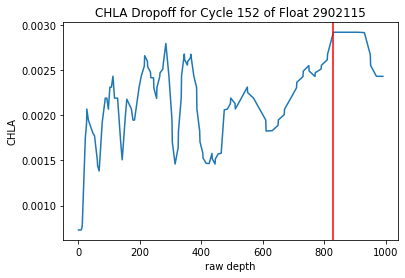

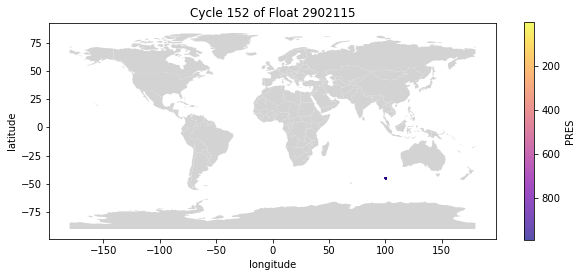

Float-cycle: 161
Number of observations in cycle: 150
Peak: 0.0069
Min after peak: 0.0069
Euphotic floor estimate: 970m


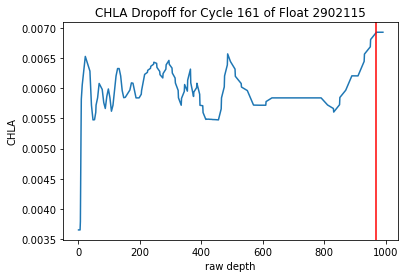

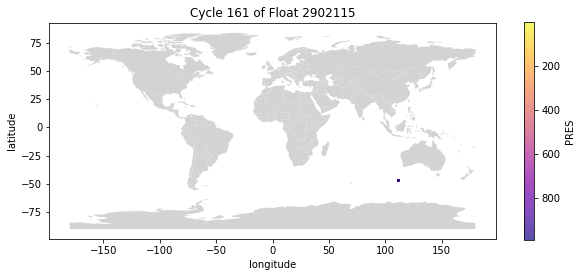

Float-cycle: 174
Number of observations in cycle: 141
Peak: 0.0029
Min after peak: 0.0026
Euphotic floor estimate: 891m


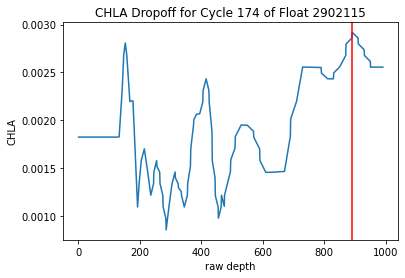

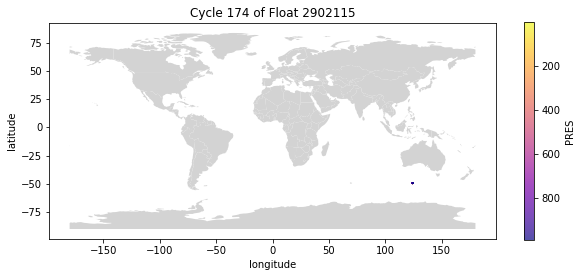

Float-cycle: 214
Number of observations in cycle: 149
Peak: 0.0037
Min after peak: 0.0034
Euphotic floor estimate: 871m


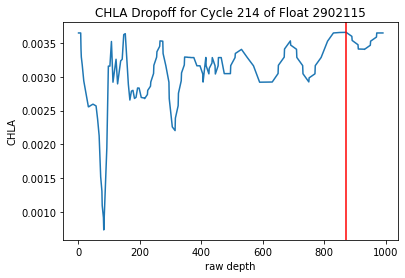

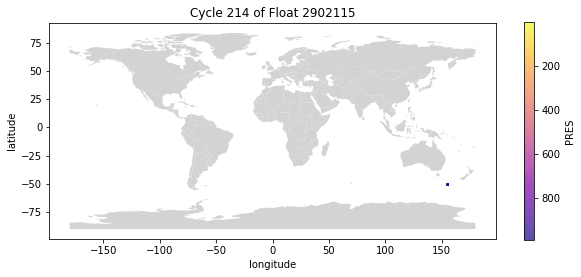

Float-cycle: 215
Number of observations in cycle: 152
Peak: 0.0001
Min after peak: 0.0001
Euphotic floor estimate: 970m


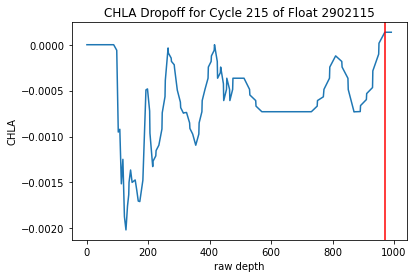

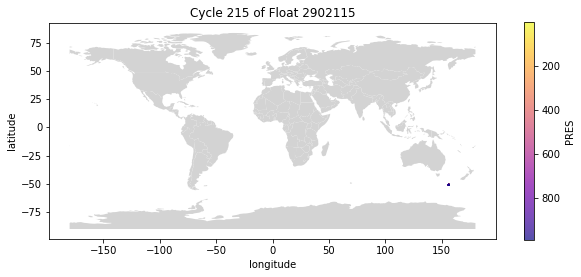

Float-cycle: 217
Number of observations in cycle: 131
Peak: 0.0035
Min after peak: 0.0032
Euphotic floor estimate: 930m


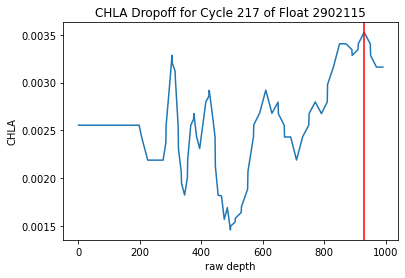

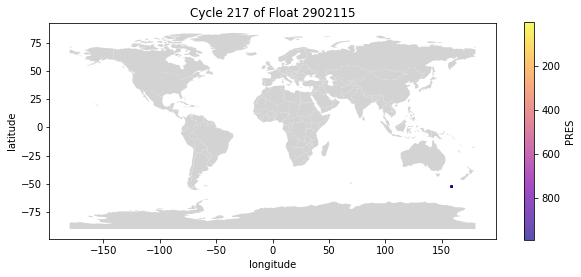

Float-cycle: 220
Number of observations in cycle: 132
Peak: 0.0027
Min after peak: 0.0024
Euphotic floor estimate: 810m


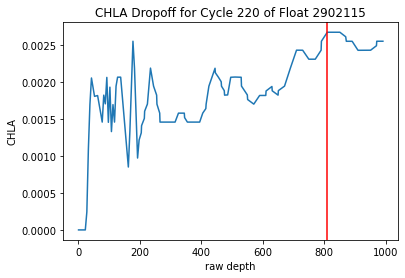

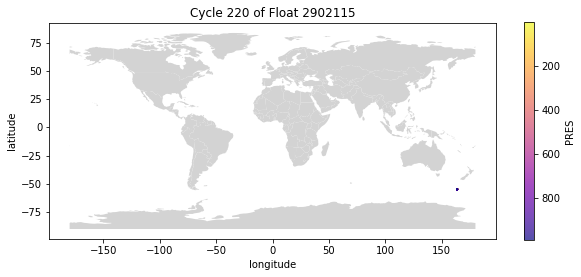

Float-cycle: 222
Number of observations in cycle: 132
Peak: -0.0006
Min after peak: 0.0000
Euphotic floor estimate: 970m


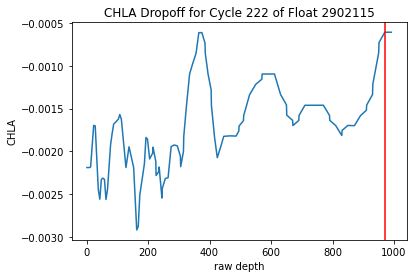

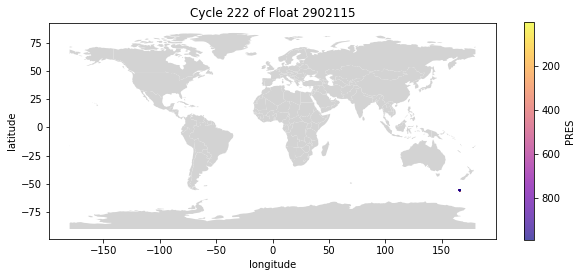

Float-cycle: 225
Number of observations in cycle: 131
Peak: 0.0001
Min after peak: 0.0001
Euphotic floor estimate: 970m


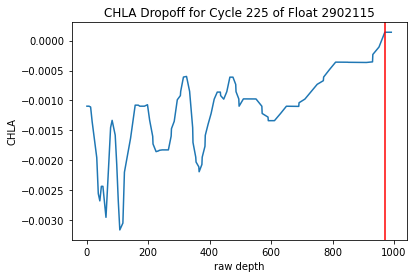

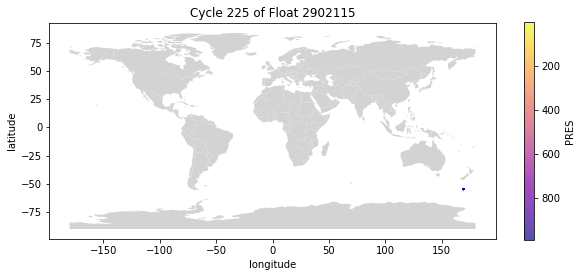

Float-cycle: 226
Number of observations in cycle: 134
Peak: 0.0001
Min after peak: 0.0000
Euphotic floor estimate: 811m


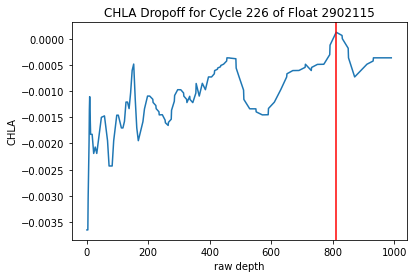

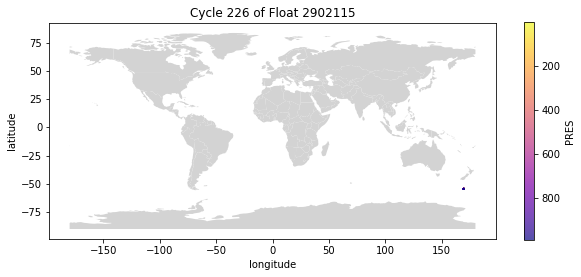

In [26]:
count = 0
for dct in estimate_not_found:
    # view cycles for which a guess could not be determined
    if dct['guess'] < 600:
        continue
    f = dct['float']
    c = dct['cycle']
    euphotic_floor_guess = dct['guess']
    float_df = df[df['float'] == f]
    cycle_df = float_df[float_df['cycleNumber'] == c].sort_values(by='PRES', ascending=True).reset_index(drop=True)
    max_chla = max(cycle_df['CHLA'])
    max_chla_idx = list(cycle_df['CHLA']).index(max_chla)
    min_chla_after_peak = max(0, min(list(cycle_df['CHLA'])[max_chla_idx:]))
    print(f'Float-cycle: {c}')
    print(f'Number of observations in cycle: {cycle_df.shape[0]}')
    print(f'Peak: {max_chla:.4f}')
    print(f'Min after peak: {min_chla_after_peak:.4f}')

    # obtain estimate for bottom of euphotic zone depth
    chla_thresh = max(min_chla_after_peak, 0.01*max_chla)

    # consider only values after the peak
    for i in range(max_chla_idx, cycle_df.shape[0]):
        if cycle_df.loc[i,'CHLA'] - chla_thresh < err:
            euphotic_floor_guess = cycle_df.loc[i,'PRES']
            break

    if euphotic_floor_guess is None:
        unit = ''
    else:
        unit='m'
    print(f'Euphotic floor estimate: {euphotic_floor_guess}{unit}')

    # visualize the guess; these examples should have no guess
    plot_chla_dropoff(cycle_df, euphotic_floor_guess=euphotic_floor_guess)
    plot_on_map(cycle_df)
    
    count += 1
    if count == 10:
        break


## Analyze the results

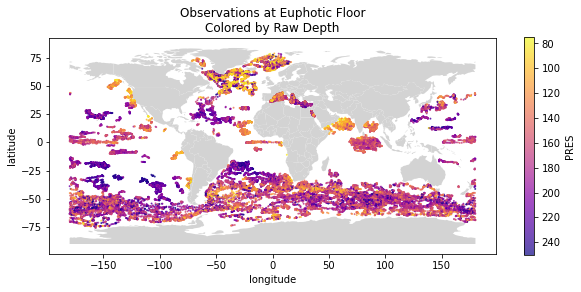

In [30]:
# display the observations colored by the depth of the euphotic floor
euphotic_floor_df = normalized_df[normalized_df['normalized_depth']==1.0].reset_index(drop=True)
plot_on_map(euphotic_floor_df, color_by='PRES', title='Observations at Euphotic Floor\nColored by Raw Depth')


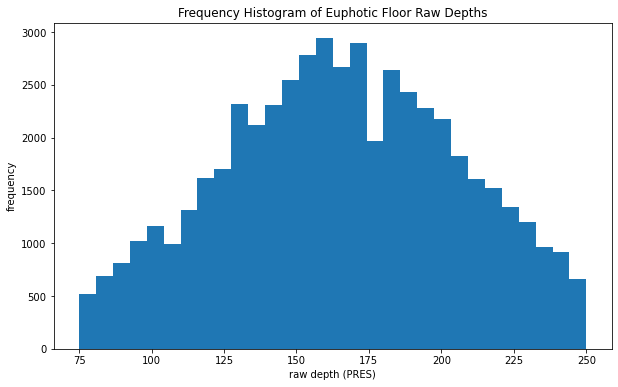

In [34]:
# display a frequency histogram of euphotic floor depths
plt.figure(figsize=(10,6))
plt.hist(euphotic_floor_df['PRES'], bins=30)
plt.title('Frequency Histogram of Euphotic Floor Raw Depths')
plt.xlabel('raw depth (PRES)')
plt.ylabel('frequency')
plt.show()


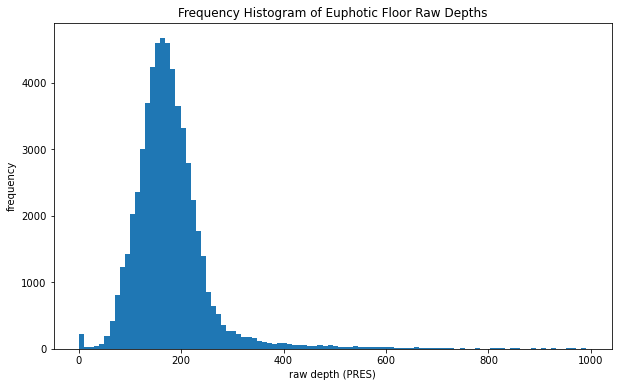

In [144]:
# note: these were the results (100 bins) when "invalid" euphotic floor depth estimates were included,
# i.e., when the guess was < 75m or > 250m

In [35]:
# check that there are no cycles for which the euphotic floor is found to be below 75m or above 250m
invalid_euphotic_floors_df = euphotic_floor_df[(euphotic_floor_df['PRES'] < 75) | (euphotic_floor_df['PRES'] > 250)].reset_index(drop=True)
invalid_euphotic_floors_df.shape


(0, 14)

## Finalize and save the dataframe

In [36]:
# add a column for the day of the year in radians
normalized_df.insert(loc=list(normalized_df.columns).index('date')+1, column='day_of_year_rad', value=[(int(d.strftime('%j'))*np.pi)/182.625 for d in normalized_df['date']])

# ensure the rows of the dataframe are unique
assert(normalized_df.shape[0] == normalized_df.drop_duplicates().shape[0])

normalized_df


,float,cycleNumber,latitude,longitude,date,day_of_year_rad,sat_chl,sat_sst,sat_pic,sat_par,sat_aph_443,PRES,normalized_depth,TEMP,CHLA
0,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,3,0.013274,12.378333,0.695875
1,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,4,0.017699,12.378333,0.695875
2,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,6,0.026549,12.378667,0.696499
3,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,8,0.035398,12.379000,0.716489
4,1902303,1,49.236,-14.742,2021-05-06 02:03:16,2.167505,0.370203,12.610,0.000306,27.891998,0.0357,10,0.044248,12.379000,0.715552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6850808,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,152,0.974359,15.741442,0.017077
6850809,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,153,0.980769,15.645053,0.016121
6850810,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,154,0.987179,15.576158,0.014904
6850811,7901001,28,17.330,-23.271,2022-05-23 11:34:00,2.459947,0.117684,23.705,0.000142,59.995998,0.0122,155,0.993590,15.528111,0.014600


In [37]:
# ensure there are no missing normalized_depth values
normalized_df.isna().sum()


float                    0
cycleNumber              0
latitude                 0
longitude                0
date                     0
day_of_year_rad          0
sat_chl             928872
sat_sst             275198
sat_pic             985501
sat_par              89375
sat_aph_443         938206
PRES                     0
normalized_depth         0
TEMP                  1617
CHLA                     0
dtype: int64

In [38]:
# save the dataframe
# note that the "invalid" cycles are NOT included in the results;
# further investigation is required into these examples before estimating the euphotic floor
result_file = 'float_sat_normalized_depth.csv'
normalized_df.to_csv(path + result_file, index=False)


In [39]:
# save information about invalid cycles
invalid_df = pd.DataFrame.from_dict(estimate_not_found)
invalid_file = 'euphotic_floor_estimate_not_found.csv'
invalid_df.to_csv(path + invalid_file, index=False)
invalid_df


,float,cycle,guess
0,1902303,19,252
1,1902304,6,62
2,1902304,10,62
3,1902304,59,61
4,1902304,60,70
...,...,...,...
6492,7900589,92,559
6493,7900589,93,706
6494,7900589,94,473
6495,7900589,95,389
